In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

import gudhi as gd
import gudhi.clustering.tomato as gdt
import gudhi.representations   as gdr

In [3]:
path = './data/3dshapes/'

In this notebook, we will show how to use the ToMATo algorithm to compute segmentations of 3D shapes, i.e., to assign labels to 3D shape vertices in an unsupervised way, that is, without training on known labels. This task was initially explored in [this article](https://www.lix.polytechnique.fr/~maks/papers/pers_seg.pdf). 

In order to visualize 3D shapes and compute clustering and statistical tests based on their Laplace-Beltrami operators, we will use the [`meshplot`](https://skoch9.github.io/meshplot/tutorial/), `statistics` and  [`robust_laplacian`](https://pypi.org/project/robust-laplacian/) Python modules.

In [5]:
# import meshplot as mp
import statistics
import robust_laplacian as rlap

We first provide a few I/O functions for reading and plotting 3D shapes and their labels. We provide a function `off2numpy` that reads information from an `.off` file and store it in two `NumPy` arrays, called `vertices` (type float and shape number_of_vertices x 3---the 3D coordinates of the vertices) and `faces` (type integer and shape number_of_faces x 3---the IDs of the vertices that create faces). We also provide a function `get_labels` that stores the face labels of a given 3D shape in a `NumPy` array (type string or integer and shape [number_of_faces].  

In [6]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces

In [7]:
def get_labels(label_name, num_faces):
    L = np.empty([num_faces], dtype='|S100')
    with open(label_name, 'r') as S:
        info = S.readlines()
    labels, face_indices = info[0::2], info[1::2]
    for ilab, lab in enumerate(labels):
        indices = [int(f)-1 for f in face_indices[ilab].split(' ')[:-1]]
        L[  np.array(indices)  ] = lab[:-1]
    return L

If `meshplot` does not work, we also provide a fix with `matplotlib` using a function that turns face labels into point labels for 3D scatter plots.

In [8]:
def face2points(vals_faces, faces, num_vertices):
    vals_points = np.empty([num_vertices], dtype=type(vals_faces))
    for iface, face in enumerate(faces):
        vals_points[face] = vals_faces[iface]
    return vals_points

Overall, the main idea is to run ToMATo on the neighborhood graph given by the triangulation of the 3D shape, with the so-called Heat Kernel Signature (HKS) as the filter. This is motivated by the fact that the HKS function typically takes higher values on the parts of the 3D shape that are very curved (such as, e.g., the tips of fingers in human hand shapes).  

The HKS was defined in [this article](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1467-8659.2009.01515.x). It is related to the heat equation on a given 3D shape $S$:

$$\Delta_S f = -\frac{\partial f}{\partial t}.$$

More formally, the HKS function  with parameter $t >0$ on a vertex $v\in S$, and denoted by ${\rm HKS}_t(v)$, is computed as:

$${\rm HKS}_t(v) = \sum_{i=0}^{+\infty} {\rm exp}(-\lambda_i\cdot t)\cdot \phi_i^2(v),$$

where $\{\lambda_i, \phi_i\}_i$ are the eigenvalues and eigenvectors of $\Delta_S$.
Intuitively, ${\rm HKS}_t(v)$ is the amount of heat remaining on $v$ at time $t$, after unit sources of heat have been placed on each vertex at time `t=0`.

Let's first pick a 3D shape. For instance, use `Hand/181.off` (or any other one you would like to try).

In [15]:
dataset_path = '/Users/hyelimlee/Desktop/DSAI/Semester1/med/Geometry_topology/LabeledDB_new/'
vertices, faces = off2numpy(dataset_path + 'Hand/181.off')
label_faces = get_labels(dataset_path + 'Hand/181_labels.txt', len(faces))
# mp.plot(vertices, faces, c=skp.LabelEncoder().fit_transform(label_faces))

<IPython.core.display.Javascript object>


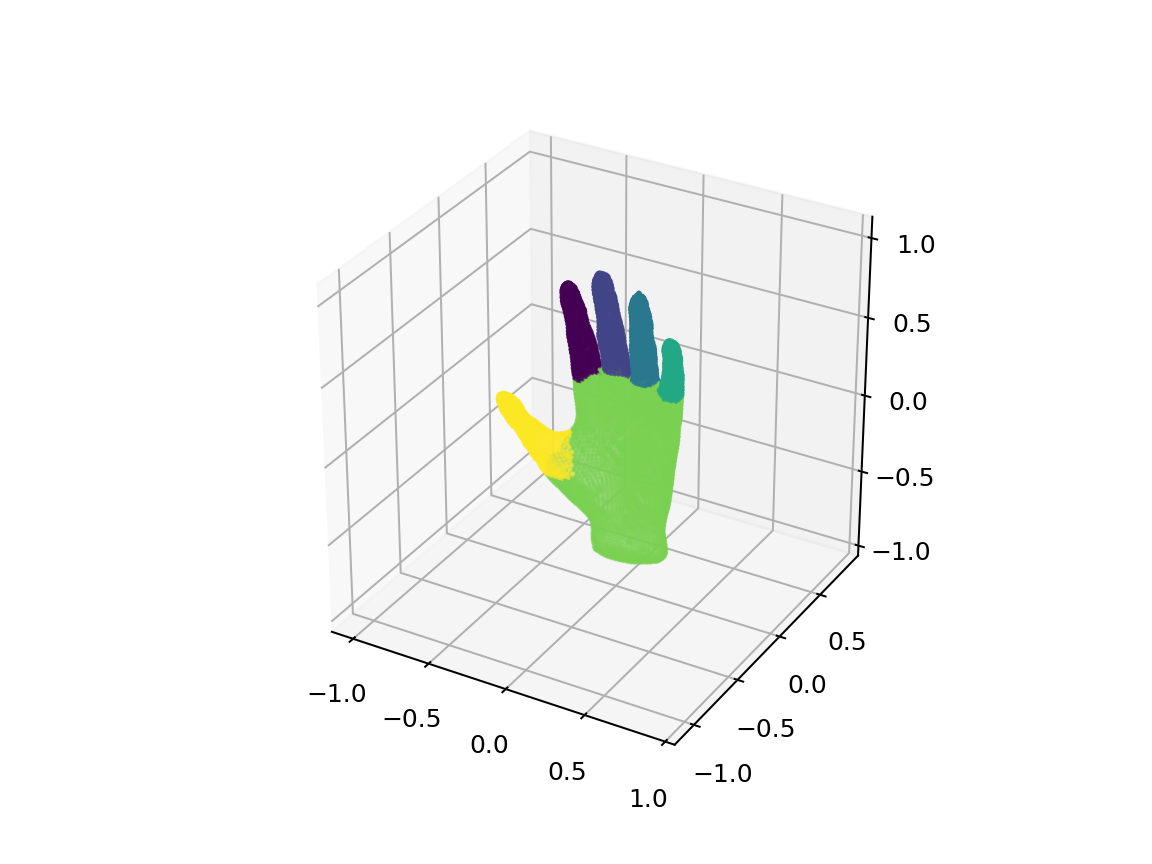

In [16]:
# If meshplot is not working
def set_axes_equal(ax: plt.Axes):
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(
    face2points(label_faces, faces, len(vertices))))
set_axes_equal(ax)
plt.show()

Now, we use `robust_laplacian` to compute the first 200 eigenvalues and eigenvectors of its Laplacian, as well as the corresponding HKS functions.

In [17]:
laplacian, mass = rlap.mesh_laplacian(vertices, faces)
egvals, egvecs = sp.sparse.linalg.eigsh(laplacian, 200, mass, sigma=1e-8)

In [18]:
def HKS(t, egvals, evecs):
    return np.sum(np.multiply( np.exp(-egvals * t)[None,:], np.square(egvecs) ), axis=1)

Let's visualize the function values with `meshplot` for time `t=0.1`.

In [19]:
# mp.plot(vertices, faces, c=HKS(1e-1, egvals, egvecs))

NameError: name 'mp' is not defined

<IPython.core.display.Javascript object>


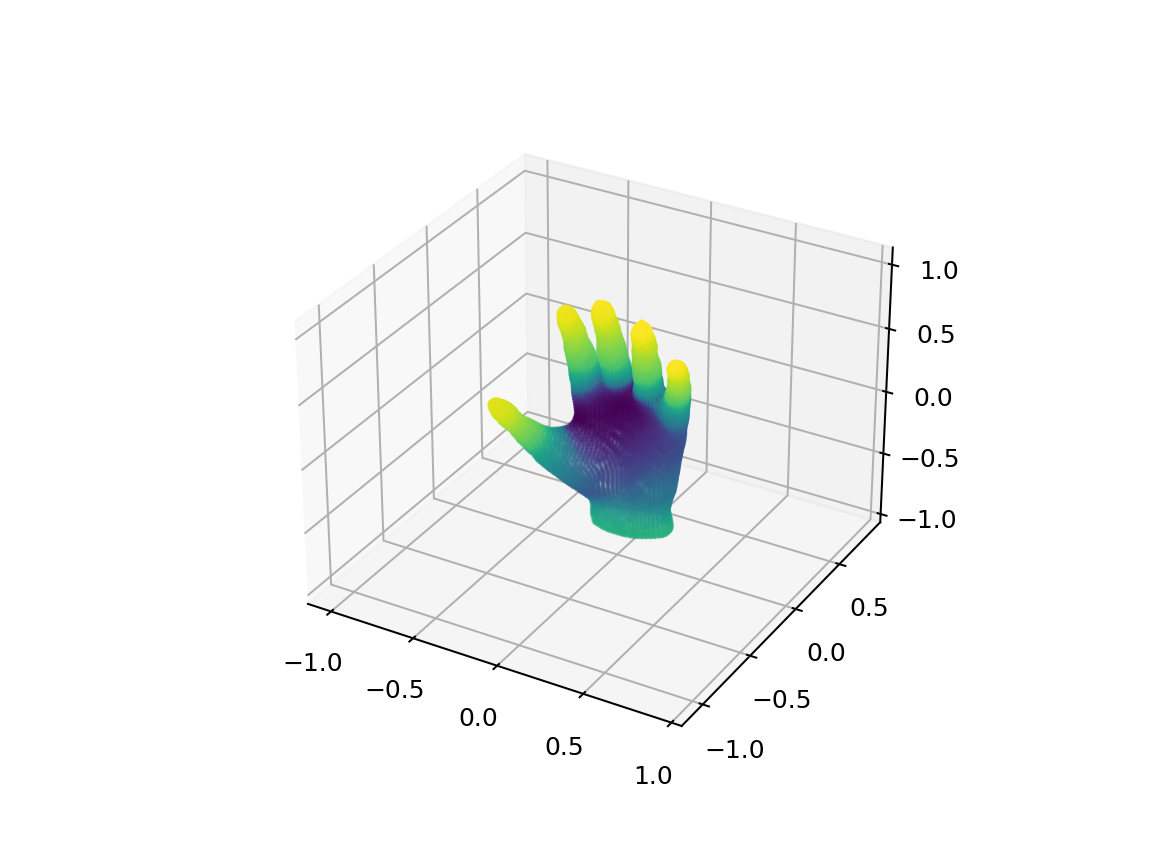

In [27]:
# If meshplot is not working
fig = plt.figure()
ax.set_aspect('equal')
ax = fig.add_subplot(projection='3d')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(HKS(1e-1, egvals, egvecs)))
set_axes_equal(ax)
plt.show()

Recall that ToMATo requires, in addition to the filter, a neighborhood graph built on top of the data. Fortunately, we can use the triangulations of our 3D shapes as input graphs! Hence, we provide a function `get_neighborhood_graph_from_faces` that computes a neighborhood graph (in the format required by ToMATo) from the faces of a triangulation. 

In [30]:
def get_neighborhood_graph_from_faces(faces, num_vertices):
    NG = [[] for _ in range(num_vertices)]
    for face in faces:
        [i1, i2, i3] = face
        NG[i1].append(i2)
        NG[i2].append(i1)
        NG[i2].append(i3)
        NG[i3].append(i2)
        NG[i1].append(i3)
        NG[i3].append(i1)
    NG = [np.unique(neighbs) for neighbs in NG]
    return NG

Finally, we can apply ToMATo (with no prior on the number of clusters or merging threshold) on the neighborhood graph and the HKS function associated to a given time parameter.

In [29]:
neighborhood_graph = get_neighborhood_graph_from_faces(faces, len(vertices))
function = HKS(1e-1, egvals, egvecs)

In [37]:
faces[0]

array([7, 0, 8])

In [29]:
tomato = gdt.Tomato(graph_type='manual', density_type='manual', n_clusters=None, merge_threshold=0)
tomato = tomato.fit(X=neighborhood_graph, weights=function)

Let's visualize the persistence diagram produced by ToMATo.

<IPython.core.display.Javascript object>


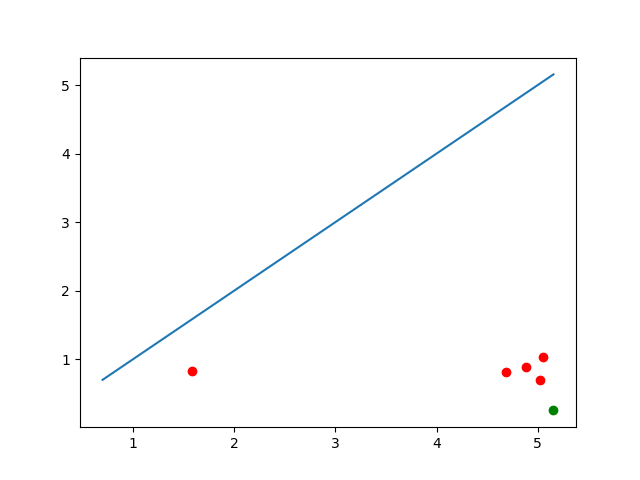

In [30]:
plt.figure()
tomato.plot_diagram()
plt.show()

Since five points are clearly standing out of the diagonal, we can use this number to re-cluster.

In [31]:
tomato.n_clusters_ = 6

Let's visualize the 3D shape again with the new ToMATo labels.

In [32]:
mp.plot(vertices, faces, c=tomato.labels_)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.042500…

<IPython.core.display.Javascript object>


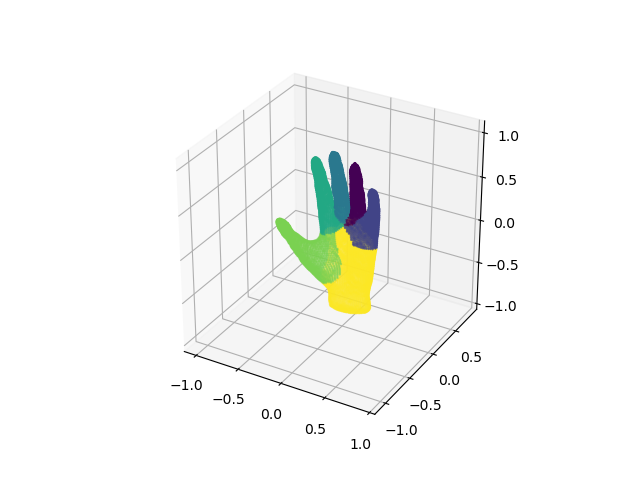

In [33]:
# If meshplot is not working
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(tomato.labels_))
set_axes_equal(ax)
plt.show()

That first segmentation is not so bad! Since the boundaries are driven by the elder rule, they can seem a bit shaggy. In order to fix this, we can use bootstrap-like smoothing. The idea is to first save the current ToMATo clustering obtained with filter $f$ (let's call it the initial clustering), and then perturb $f$ a little bit into another function $\tilde f$, and finally recompute clustering with ToMATo using $\tilde f$. Since clusters are now created with the maxima of $\tilde f$ (which will be different in general from those of $f$), we can use the initial clustering to relate the clusters of $\tilde f$ to those of $f$, by simply looking at which (initial) clusters do the maxima of $\tilde f$ belong to. If we repeat this procedure $N$ times, we will end up with a distribution (of size $N$) of candidate clusters for each vertex $v$. It suffices to pick the most frequent one for each vertex to get a smooth segmentation for the 3D shape. See also Section 6 in [the article](https://www.lix.polytechnique.fr/~maks/papers/pers_seg.pdf).

In order to implement this, we provide a function `get_indices_of_maxima` which computes the indices of the maxima  associated to a set of ToMATo clusters.

In [34]:
def get_indices_of_maxima(label_points, function):
    Li = np.copy(label_points)
    for lab in np.unique(label_points):
        inds = np.argwhere(label_points == lab).ravel()
        imax = np.argmax(function[inds]).ravel()
        Li[inds] = inds[imax]
    return Li

Let's compute and plot these maxima on the 3D shape.

In [35]:
tomato_maxima = get_indices_of_maxima(tomato.labels_, function)

In [36]:
unique_tomato_maxima = np.unique(tomato_maxima)
vertex_show = np.concatenate([unique_tomato_maxima] + [neighborhood_graph[m] for m in unique_tomato_maxima])
mp.plot(vertices, faces, c=np.array([1 if i in vertex_show else 0 for i in range(len(vertices))]))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.042500…

<IPython.core.display.Javascript object>


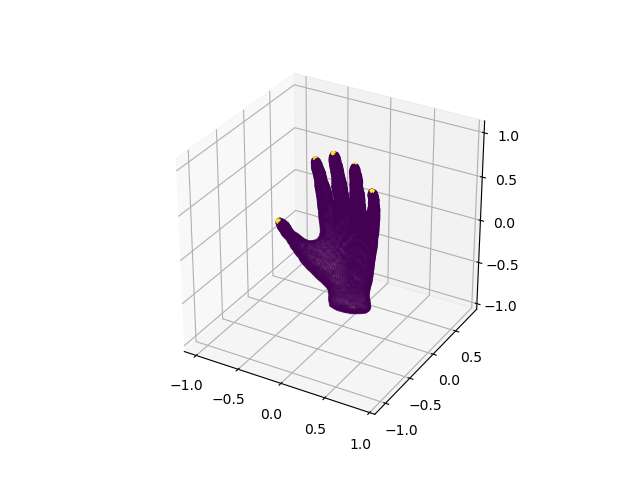

In [37]:
unique_tomato_maxima = np.unique(tomato_maxima)
vertex_show = np.concatenate([unique_tomato_maxima] + [neighborhood_graph[m] for m in unique_tomato_maxima])
# If meshplot is not working
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(np.array([1 if i in vertex_show else 0 for i in range(len(vertices))])))
set_axes_equal(ax)
plt.show()

Now, we can use this function to write another function `bootstrap_tomato` that performs a bootstrap smoothing of a set to ToMATo labels. This function takes as arguments a number $N$ of bootstrap iterations, and a parameter $\epsilon$ controlling the amplitude of the uniform noise used to perturb the filter.

In [38]:
def bootstrap_tomato(tomato_maxima, epsilon, N=100, num_labels=None):
    distribution_maxima = np.zeros(shape=[len(tomato_maxima), N])
    for n in range(N):
        if (n+1) % 100 == 0:
            print(str(n+1) + '/' + str(N))
        np.random.seed(n)
        noisy_function = function + np.random.uniform(low=-epsilon, high=epsilon, size=function.shape)
        tomato_boot = gdt.Tomato(graph_type='manual', density_type='manual', n_clusters=num_labels)
        tomato_boot.fit(X=neighborhood_graph, weights=noisy_function)
        maxima_boot = get_indices_of_maxima(tomato_boot.labels_, noisy_function)
        distribution_maxima[:,n] = tomato_maxima[maxima_boot]
    final_labels = np.array([int(statistics.mode(distribution_maxima[i,:])) for i in range(len(tomato_maxima))])
    return skp.LabelEncoder().fit_transform(final_labels)

Let's apply the bootstrap smoothing and visualize the segmentation.

In [48]:
final_labels = bootstrap_tomato(tomato_maxima, epsilon=10, N=1000, num_labels=5)

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000


In [49]:
mp.plot(vertices, faces, c=final_labels)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.042500…

<IPython.core.display.Javascript object>


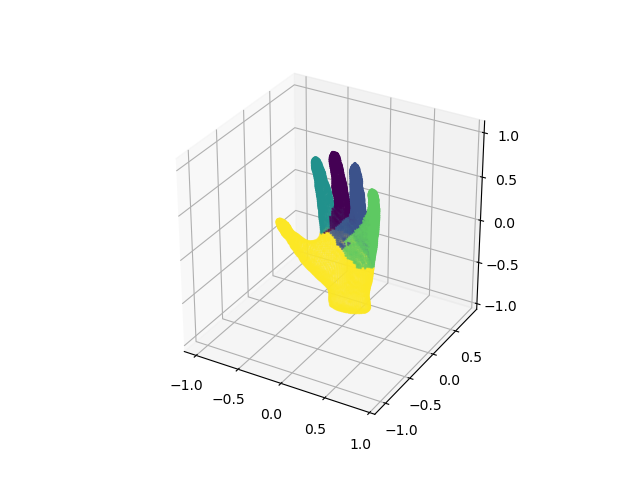

In [50]:
# If meshplot is not working
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], s=1, 
           c=skp.LabelEncoder().fit_transform(final_labels))
set_axes_equal(ax)
plt.show()

The segmentation looks better indeed!